# Latent mapper

## Установка пакетов

In [2]:
!git clone https://github.com/orpatashnik/StyleCLIP.git

import os
os.chdir(f'./StyleCLIP')

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Клонирование в «stylegan3»...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207 (from 1)
Получение объектов: 100% (212/212), 4.17 МиБ | 351.00 КиБ/с, готово.
Определение изменений: 100% (98/98), готово.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yk3wjphe
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yk3wjphe
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip i

In [2]:
!pip install gdown

!gdown https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
!mv stylegan2-ffhq-config-f.pt pretrained_models


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Downloading...
From (original): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
From (redirected): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT&confirm=t&uuid=79ee67e0-39f3-4adc-880e-841b06fb02a8
To: /home/vlad/StyleCLIP-main/new_notebooks/StyleCLIP/stylegan2-ffhq-config-f.pt
100%|█████████████████████████████████████████| 381M/381M [13:13<00:00, 481kB/s]


In [3]:
!gdown https://drive.google.com/uc?id=1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL
!mv model_ir_se50.pth pretrained_models

Downloading...
From (original): https://drive.google.com/uc?id=1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL
From (redirected): https://drive.google.com/uc?id=1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL&confirm=t&uuid=f2695443-b382-4333-9d41-ad403a6d7e34
To: /home/vlad/StyleCLIP-main/new_notebooks/StyleCLIP/model_ir_se50.pth
100%|█████████████████████████████████████████| 175M/175M [06:15<00:00, 467kB/s]


## Если они установлены

In [1]:
import os
os.chdir(f'./StyleCLIP')

In [2]:
import torch
import numpy as np
import torchvision.transforms as T
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from models.stylegan2.model import EqualLinear, PixelNorm
from models.stylegan2.model import Generator #StyleGAN
import ipywidgets as widgets
import clip #CLIP
from models.facial_recognition.model_irse import Backbone #ArcFace

## Загрузка готовых моделей

In [3]:
class Mapper(torch.nn.Module):
    def __init__(self, latent_dim = 512):
        super(Mapper, self).__init__()
        
        el = EqualLinear(latent_dim, latent_dim, lr_mul = 0.01, activation = "fused_lrelu")
        layers = [PixelNorm(), el, el, el, el]
        self.mapping = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.mapping(x)
        return x

In [4]:
def check_high_mem_gpu(size):
    return torch.cuda.get_device_properties(0).total_memory > size * 1024**3

device1 = "cuda" if torch.cuda.is_available() else "cpu"
# Запускаем CLIP на ЦП, если мало видеопамяти
device2 = "cuda" if torch.cuda.is_available() and check_high_mem_gpu(3) else "cpu"
device3 = "cuda" if torch.cuda.is_available() else "cpu"

sg_weights = "pretrained_models/stylegan2-ffhq-config-f.pt"
af_weighs = "pretrained_models/model_ir_se50.pth"

# Чем больше видеопамяти - тем выше качество картинки
if check_high_mem_gpu(8):
    sg = Generator(512, 512, 8)
    batch_size = 512
if check_high_mem_gpu(7):
    sg = Generator(256, 512, 8)
    batch_size = 256
elif check_high_mem_gpu(6):
    sg = Generator(128, 512, 8)
    batch_size = 128
elif check_high_mem_gpu(5):
    sg = Generator(64, 512, 8)
    batch_size = 64
elif check_high_mem_gpu(4):
    sg = Generator(32, 512, 8)
    batch_size = 32
else:
    sg = Generator(16, 512, 8)
    batch_size = 16

mp = Mapper(512).to(device1)
sg.load_state_dict(torch.load(sg_weights)["g_ema"], strict = False)
sg = sg.to(device1)
cl_m, _ = clip.load("ViT-B/32", device = device2)
af = Backbone(input_size = 112, num_layers = 50, drop_ratio = 0.6, mode = "ir_se")
af.load_state_dict(torch.load(af_weighs))
af = af.to(device3)

/tmp/ipykernel_16355/838144541.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sg.load_state_dict(torch.load(sg_weights)["g_ema"], strict = False)
/tmp/ipykernel_16355/

## Функции потерь

In [5]:
import torchvision.transforms.functional as F
import gc

def preprocess_img(img):
    dim = img.shape[2]
    mult = 224 / dim
    upsample = torch.nn.Upsample(scale_factor = mult)
    pre_img = upsample(img)
    return pre_img

def clip_loss(img_emb, text_emb):
    return (1 - cl_m(img_emb.to(device2), text_emb)[0] / 100).mean()

def l2_loss(w_coef, w_pred, w_true):
    return w_coef * torch.norm(w_pred - w_true, p = 2).cpu()

def id_regul(w_coef, emb_pred, emb_true):
    if not check_high_mem_gpu(6): # Снижаем качество картинки для бюджетных видеокарт
        avg_pool1 = torch.nn.Upsample(scale_factor = 0.5)
        avg_pool2 = torch.nn.Upsample(scale_factor = 0.5)
        emb_pred = avg_pool1(emb_pred)
        emb_true = avg_pool2(emb_true)
    emb_pred = emb_pred.reshape(-1, 3, 112, 112).to(device3)
    emb_true = emb_true.reshape(-1, 3, 112, 112).to(device3)
    face_pred = af(emb_pred).cpu().mean(0).flatten()
    face_true = af(emb_true).cpu().mean(0).flatten()
    return w_coef * (1 - torch.dot(face_pred, face_true.T))

def total_loss(w_coef1, w_coef2, source_latent, my_latent, source_img_emb, my_img_emb, text_emb):
    pre_img_0 = preprocess_img(source_img_emb)
    pre_img = preprocess_img(my_img_emb)
    first = clip_loss(pre_img, text_emb)
    second = l2_loss(w_coef1, source_latent, my_latent)
    third = id_regul(w_coef2, pre_img, pre_img_0)
    return first + second + third

In [6]:
criterion = total_loss

## Mapper

In [7]:
from copy import copy

def get_keys(d, name):
    if 'state_dict' in d:
        d = d['state_dict']
    d_filt = {k[len(name) + 1:]: v for k, v in d.items() if k[:len(name)] == name}
    return d_filt

class LevelsMapper(torch.nn.Module):
    def __init__(self, mp, layers = [True, True, True]):
        super(LevelsMapper, self).__init__()

        self.layers = layers
        if layers[0]:
            self.coarse_mapping = copy(mp)
        if layers[1]:
            self.medium_mapping = copy(mp)
        if layers[2]:
            self.fine_mapping = copy(mp)

    def forward(self, x):
        x_coarse = x[ : 4, : ]
        x_medium = x[4 : 8, : ]
        x_fine = x[8 : , : ]

        if layers[0]:
            x_coarse = self.coarse_mapping(x_coarse)
        else:
            x_coarse = torch.zeros_like(x_coarse)
        if layers[1]:
            x_medium = self.medium_mapping(x_medium)
        else:
            x_medium = torch.zeros_like(x_medium)
        if layers[2]:
            x_fine = self.fine_mapping(x_fine)
        else:
            x_fine = torch.zeros_like(x_fine)

        out = torch.cat([x_coarse, x_medium, x_fine], dim = 0)
        return out

In [8]:
class StyleCLIPMapper(torch.nn.Module):
    def __init__(self, sg, mp, checkpoint = ""):
        super(StyleCLIPMapper, self).__init__()
        self.checkpoint = checkpoint
        # Define architecture
        self.mapper = mp
        self.decoder = sg
        self.face_pool = torch.nn.AdaptiveAvgPool2d((256, 256))
        # Load weights if needed
        self.load_weights()

    def load_weights(self):
        if self.checkpoint:
            print("Loading from checkpoint: {}".format(self.checkpoint))
            ckpt = torch.load(self.checkpoint, map_location = device1)
            self.mapper.load_state_dict(get_keys(ckpt, "mapper"), strict = False)
            self.decoder.load_state_dict(get_keys(ckpt, "decoder"), strict = False)
        else:
            print("Loading decoder weights from pretrained!")
            ckpt = torch.load(sg_weights)
            self.decoder.load_state_dict(ckpt["g_ema"], strict = False)

    def forward(self, x, inject_latent = None, alpha = None):
        codes = self.mapper(x)

        images, result_latent = self.decoder([codes], input_is_latent = True, randomize_noise = False, return_latents = True)
        images = self.face_pool(images)

        return images, result_latent


## Тренировка

In [9]:
def train(net, w_coef1, w_coef2, lat_train, lat_test, text, imgs_train = torch.empty((0, 1)), imgs_test = torch.empty((0, 1)), lr = 0.01, epochs = 15):
    params = list(net.mapper.parameters())
    optimizer = torch.optim.AdamW(params, lr = lr)
    net.train()
    text_emb = torch.cat([clip.tokenize(text)]).to(device2)
    train_losses = []
    val_losses = []
    real = bool(len(imgs_train))
    
    for epoch in tqdm(range(epochs)):
        avg_loss = 0
        count = len(train_data)
        for batch_idx, batch in enumerate(lat_train):
            optimizer.zero_grad()
            w = batch.to(device1)
            if real:
                x = imgs_train[batch_idx]
            else:
                with torch.no_grad():
                    x, _ = net.decoder([w], input_is_latent = True, randomize_noise = False, truncation = 1, input_is_stylespace = False)
            w_hat = w + 0.1 * net.mapper(w)
            x_hat, w_hat, _ = net.decoder([w_hat], input_is_latent = True, return_latents = True, randomize_noise = False, truncation = 1)
            x, x_hat, w, w_hat = x.detach().cpu(), x_hat.detach().cpu(), w.detach().cpu(), w_hat.detach().cpu()
            loss = criterion(w_coef1, w_coef2, w, w_hat, x, x_hat, text_emb)
            loss.backward()
            avg_loss += loss.item()
            optimizer.step()
            
        train_losses.append(avg_loss / count)
        val_loss = validate(net, w_coef1, w_coef2, lat_test, epoch, text_emb, imgs_test)
        val_losses.append(val_loss)
        checkpoint_me(net, epoch)
        
    return net, train_losses, val_losses

def validate(net, w_coef1, w_coef2, lat_test, epoch, text_emb, imgs_test):
    net.eval()
    avg_loss = 0
    count = len(test_data)
    real = bool(len(imgs_test))
    
    for batch_idx, batch in enumerate(lat_test):
        w = batch.to(device1)
        if real:
            x = imgs_test[batch_idx]
        else:
            with torch.no_grad():
                x, _ = net.decoder([w], input_is_latent = True, randomize_noise = False, truncation = 1, input_is_stylespace = False)
        w_hat = w + 0.1 * net.mapper(w)
        x_hat, w_hat, _ = net.decoder([w_hat], input_is_latent = True, return_latents = True, randomize_noise = False, truncation = 1)
        x, x_hat, w, w_hat = x.detach().cpu(), x_hat.detach().cpu(), w.detach().cpu(), w_hat.detach().cpu()
        loss = criterion(w_coef1, w_coef2, w, w_hat, x, x_hat, text_emb)
        avg_loss += loss.item()

    net.train()
    return avg_loss / count

def checkpoint_me(model, epoch):
    save_name = "iteration_{}.pt".format(epoch)
    save_dict = model.state_dict()
    torch.save(save_dict, save_name)

## Вывод

In [42]:
def inference(net, lat_infer):
    result_images = torch.zeros((len(lat_infer), 6, 3, 16, 16))
    for ind, input_batch in tqdm(enumerate(lat_infer)):
        with torch.no_grad():
            input_img = input_batch.to(device1)
            result_batch = inference_on_batch(input_img, net)
            result_images[ind] = result_batch
    return result_images

def inference_on_batch(inputs, net):
    w = inputs
    with torch.no_grad():
        w_hat = w + 0.1 * net.mapper(w)
        x_hat, _ = net.decoder([w_hat], input_is_latent = True, randomize_noise = False, truncation = 1)
    return x_hat.cpu()

In [11]:
Epochs = widgets.BoundedIntText(
    value = 15,
    min = 5,
    max = 30,
    step = 5,
    description = "Итераций:",
    disabled = False
)

Lr = widgets.BoundedFloatText(
    value = 0.1,
    min = 0.0001,
    max = 1,
    step = 0.0001,
    description = "Скорость обучения:",
    disabled = False
)

W_coef1 = widgets.BoundedFloatText(
    value = 0.008,
    min = 0.001,
    max = 0.01,
    step = 0.001,
    description = "$Lambda_{L2}:$",
    disabled = False
)

W_coef2 = widgets.BoundedFloatText(
    value = 0.005,
    min = 0.001,
    max = 0.01,
    step = 0.001,
    description = "$Lambda_{ID}:$",
    disabled = False
)

Text = widgets.Text(
    value = "High middle-aged woman",
    placeholder = "Введите описание",
    disabled = False
)

Coarse = widgets.Checkbox(
    value = True,
    description = "Приблизительный слой",
    disabled = False
)

Medium = widgets.Checkbox(
    value = True,
    description = "Средний слой",
    disabled = False
)

Fine = widgets.Checkbox(
    value = True,
    description = "Точный слой",
    disabled = False
)

Checkpoint = widgets.Text(
    value = "",
    placeholder = "Введите путь к файлу",
    disabled = False
)

display(Epochs)
display(Lr)
display(W_coef1)
display(W_coef2)
display(Text)
display(Coarse)
display(Medium)
display(Fine)
display(Checkpoint)

epochs = Epochs.value
lr = Lr.value
w_coef1 = W_coef1.value
w_coef2 = W_coef2.value
text = Text.value

layers = [Coarse.value, Medium.value, Fine.value]

checkpoint = Checkpoint.value

BoundedIntText(value=15, description='Итераций:', max=30, min=5, step=5)

BoundedFloatText(value=0.1, description='Скорость обучения:', max=1.0, min=0.0001, step=0.0001)

BoundedFloatText(value=0.008, description='$Lambda_{L2}:$', max=0.01, min=0.001, step=0.001)

BoundedFloatText(value=0.005, description='$Lambda_{ID}:$', max=0.01, min=0.001, step=0.001)

Text(value='High middle-aged woman', placeholder='Введите описание')

Checkbox(value=True, description='Приблизительный слой')

Checkbox(value=True, description='Средний слой')

Checkbox(value=True, description='Точный слой')

Text(value='', placeholder='Введите путь к файлу')

In [43]:
def generate_images(latent):
    with torch.no_grad():
        _, img, _ = sg([latent.to(device1)], input_is_latent = True, return_latents = True)
    return img.detach().cpu()

## Запуск

In [13]:
z1 = torch.randn(3000, 512)
z2 = torch.randn(2000, 512)
train_data = DataLoader(z1, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_data = DataLoader(z2, batch_size = batch_size, shuffle = False, num_workers = 1, drop_last = True)

imgs_train = torch.cat([generate_images(cur_z) for cur_z in train_data])
imgs_test = torch.cat([generate_images(cur_z) for cur_z in test_data])

torch.cuda.empty_cache()

mapper = LevelsMapper(mp, layers)
scmapper = StyleCLIPMapper(sg, mapper, checkpoint)

model, train_losses, val_losses = train(scmapper, w_coef1, w_coef2, imgs_train, imgs_test, text, lr = lr, epochs = epochs)

Loading decoder weights from pretrained!


/tmp/ipykernel_16355/2283037997.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(sg_weights)


  0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_16355/3745044634.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return w_coef * (1 - torch.dot(face_pred, face_true.T))


In [44]:
z0 = torch.randn(200, 512)
infer_data = DataLoader(z0, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

imgs_infer = torch.cat([generate_images(cur_z) for cur_z in infer_data])

imgs_pred = inference(model, imgs_infer)
imgs_pred = imgs_pred.reshape(-1, 3, 16, 16)

imgs_pred = torch.permute(imgs_pred, (0, 2, 3, 1))

0it [00:00, ?it/s]

## Сравнение изображений

In [45]:
def normalize(cur_img):
    min_img = cur_img.min()
    max_img = cur_img.max()
    cur_img -= min_img
    diff_img = max_img - min_img
    cur_img /= diff_img
    return cur_img

imgs_pred = normalize(imgs_pred)

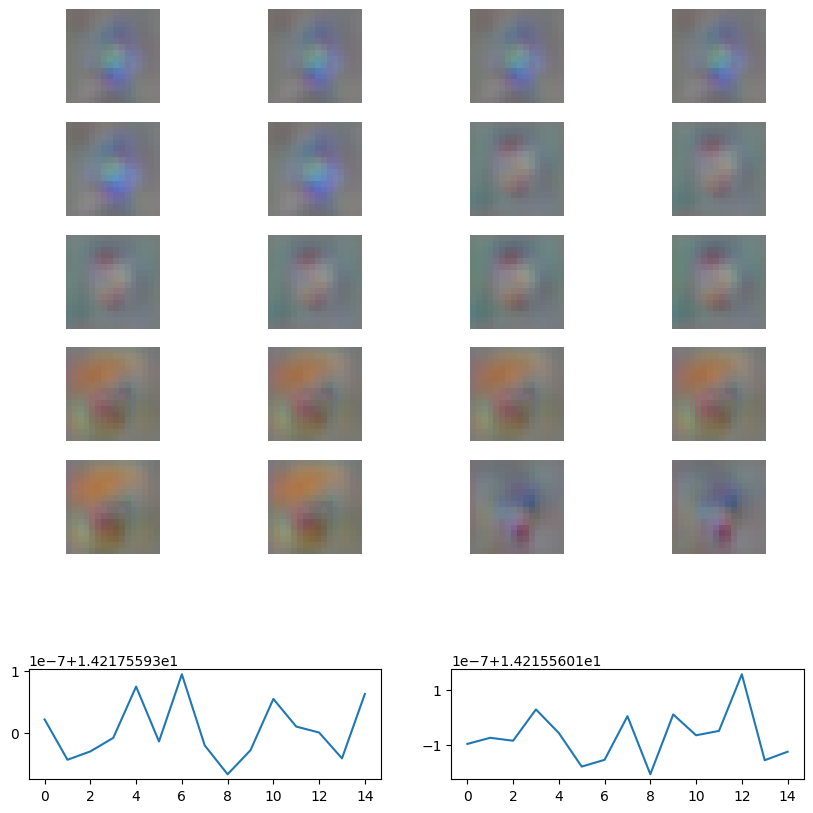

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for ind in range(20):
    plt.subplot(7, 4, ind + 1)
    plt.axis("off")
    plt.imshow(imgs_pred[ind])
plt.subplot(6, 2, 11)
plt.plot(range(epochs), train_losses)
plt.subplot(6, 2, 12)
plt.plot(range(epochs), val_losses)
plt.show()

Есть попытка сгенерировать женщину, но она не очень удачная.

# Эксперименты

### Эксперимент 1

Убираем точный слой.

In [17]:
checkpoint = "iteration_14.pt"

layers = [True, True, False]

mapper = LevelsMapper(mp, layers)
scmapper = StyleCLIPMapper(sg, mapper, checkpoint)

imgs_pred = inference(scmapper, infer_data)
imgs_pred = imgs_pred.reshape(-1, 3, 16, 16)
imgs_pred = torch.permute(imgs_pred, (0, 2, 3, 1))

imgs_pred = normalize(imgs_pred)

Loading from checkpoint: iteration_14.pt


/tmp/ipykernel_16355/2283037997.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(self.checkpoint, map_location = device1)


0it [00:00, ?it/s]

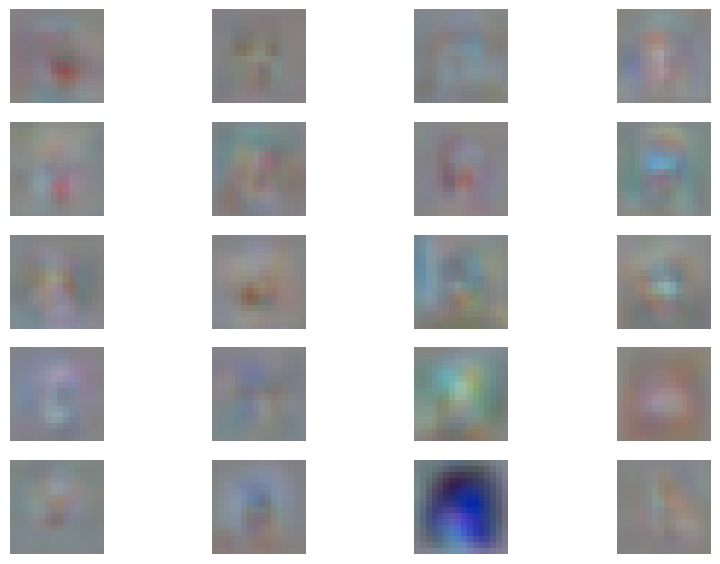

In [18]:
plt.figure(figsize = (10, 10))
for ind in range(20):
    plt.subplot(7, 4, ind + 1)
    plt.axis("off")
    plt.imshow(imgs_pred[ind])

Не похоже на нормальные картинки.

### Эксперимент 2

Оставляем только приблизительный слой.

In [19]:
checkpoint = "iteration_14.pt"

layers = [True, False, False]

imgs_pred = inference(scmapper, infer_data)
imgs_pred = imgs_pred.reshape(-1, 3, 16, 16)
imgs_pred = torch.permute(imgs_pred, (0, 2, 3, 1))

imgs_pred = normalize(imgs_pred)

0it [00:00, ?it/s]

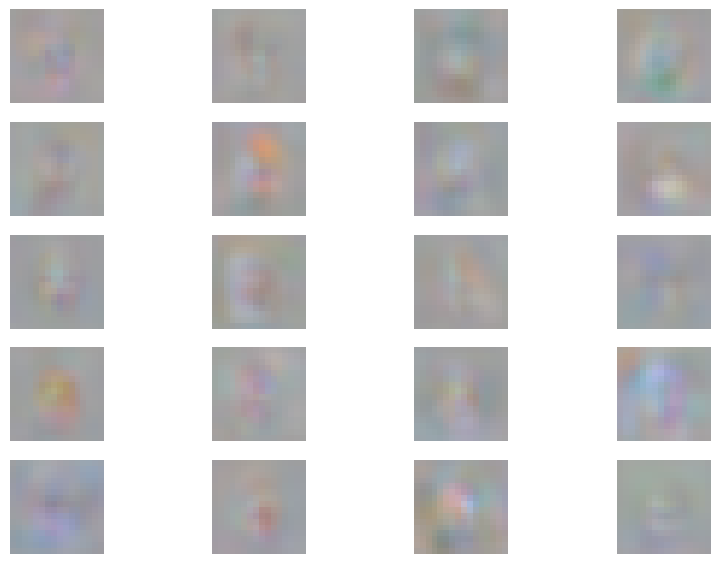

In [20]:
plt.figure(figsize = (10, 10))
for ind in range(20):
    plt.subplot(7, 4, ind + 1)
    plt.axis("off")
    plt.imshow(imgs_pred[ind])

Разницы с предыдущим особо не видно.

### Эксперимент 3

Выберем другие веса.

In [21]:
checkpoint = "iteration_11.pt"

layers = [True, False, False]

imgs_pred = inference(scmapper, infer_data)
imgs_pred = imgs_pred.reshape(-1, 3, 16, 16)
imgs_pred = torch.permute(imgs_pred, (0, 2, 3, 1))

imgs_pred = normalize(imgs_pred)

0it [00:00, ?it/s]

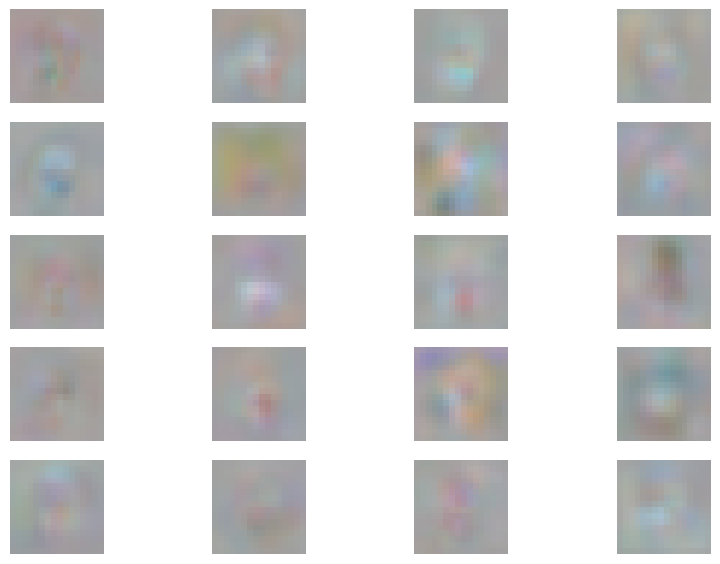

In [22]:
plt.figure(figsize = (10, 10))
for ind in range(20):
    plt.subplot(7, 4, ind + 1)
    plt.axis("off")
    plt.imshow(imgs_pred[ind])

Совершенно не похоже на картинки.

## Реальные изображения

In [23]:
def open_image(path, name, transform):
    full_path = os.path.join(path, name)
    img = Image.open(full_path)
    tr_img = transform(img)
    return tr_img

In [34]:
from PIL import Image
import torchvision.transforms as tf
import numpy as np
import random as rnd

transform = tf.Compose([tf.Resize((224, 224)), tf.ToTensor(), tf.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

base_path = "../dataset/img_align_celeba"
files = list(os.walk(base_path))[0][2]
train_files = rnd.sample(files, 3000)
test_files = rnd.sample(files, 2000)

lat_train = copy(imgs_train)
lat_test = copy(imgs_test)
lat_infer = copy(imgs_infer)

imgs_train = [open_image(base_path, name, transform) for name in train_files]
imgs_test = [open_image(base_path, name, transform) for name in test_files]

torch.cuda.empty_cache()

mapper = LevelsMapper(mp, layers)
scmapper = StyleCLIPMapper(sg, mapper, checkpoint)

model, train_losses, val_losses = train(scmapper, w_coef1, w_coef2, lat_train, lat_test, text, imgs_train, imgs_test, lr = lr, epochs = epochs)

202599
Loading from checkpoint: iteration_11.pt


/tmp/ipykernel_16355/2283037997.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(self.checkpoint, map_location = device1)


  0%|          | 0/15 [00:01<?, ?it/s]

In [47]:
imgs_pred = inference(model, lat_infer)
imgs_pred = imgs_pred.reshape(-1, 3, 16, 16)

imgs_pred = torch.permute(imgs_pred, (0, 2, 3, 1))

imgs_pred = normalize(imgs_pred)

0it [00:00, ?it/s]

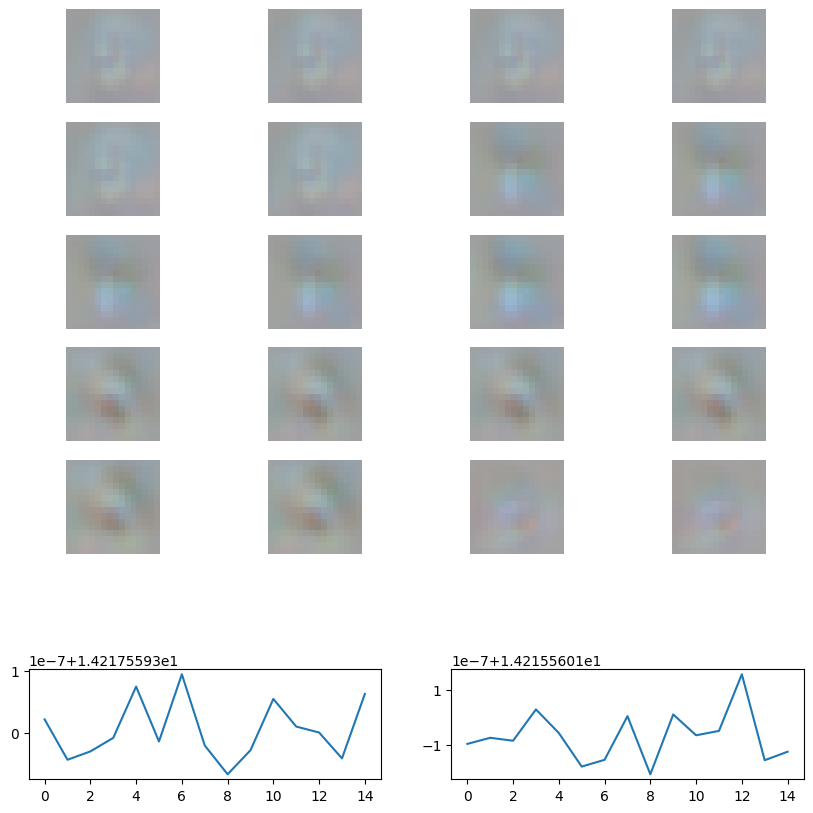

In [48]:
plt.figure(figsize = (10, 10))
for ind in range(20):
    plt.subplot(7, 4, ind + 1)
    plt.axis("off")
    plt.imshow(imgs_pred[ind])
plt.subplot(6, 2, 11)
plt.plot(range(epochs), train_losses)
plt.subplot(6, 2, 12)
plt.plot(range(epochs), val_losses)
plt.show()